# Practica 2: JPEG

En esta práctica simularemos un codificador JPEG, con cada una de sus partes: la conversión a *YCbCr*, la DCT, la cuantificación y la codificación entrópica. Es decir, implementaremos todas las fases que se pueden ver en la siguiente figura:

![JPEG encoding](./images/jpeg-encoding.png)

Para cada una de las partes se presenta una introducción a sus fundamentos, y a continuación se plantean uno o varios ejercicios. El código de estos ejercicios se escribe directamente en este notebook, mientras que las respuestas a las preguntas deben anotarse en un documento aparte.

## Transformación de color

El primer paso del codificador JPEG es convertir las matrices de componentes $R$, $G$, y $B$ de la imagen original a matrices de componentes $Y$ (luminancia), $C_B$ (crominancia azul), y $C_R$ (crominancia roja). De esta forma se separan en componentes diferentes los valores de intensidad de los de color. Como la visión humana es mas sensible a los primeros que a los segundos, el algoritmo JPEG intentará reducir mas los valores de color que los de intensidad. De esta forma el tamaño final de la imagen será menor mientras la imagen mantiene una apariencia similar a la original. 

Es importante recordar que durante esta transformación no se pierde nada de la información original, solo se transforma de un modelo de color ($RGB$) a otro ($YCbCr$).

### Ejercicio 1

Para poder construir y probar nuestro codificador JPEG, necesitamos cargar una imagen de prueba y convertirla al modelo de color *YCbCr*. Para ello utilizaremos la librería **OpenCV**, que nos proporciona diferentes funciones para el manejo de imágenes.

Para poder cargar la imagen original desde el sistema de ficheros, usaremos la función ```imread```. Esto nos cargará desde disco la información de cada pixel y lo guardará en tres matrices, una para cada componente $B$, $G$, y $R$ (ya que por defecto **OpenCV** guarda los datos en formato *BGR*).

Una vez que tenemos los valores de la imagen en una matriz, la función ```cvtColor``` nos permite efectuar las transformaciones que queramos hacia otros modelos de color. Para ello, solo devemos usar como segundo parámetro alguna de las constantes de transformación, como ```COLOR_BGR2RGB``` o ```COLOR_RGB2YCrCb```. Observa que la traducción se hace a $YCrCb$ y no a $YCbCr$.

**OpenCV** nos devuelve una matriz en tres dimensiones, donde cada dimensión se corresponde con uno de los componentes ($RGB$ o $YCbCr$). Por tanto, para acceder a cada componente tendremos que seleccionar el indice correspondiente:


$$
mat\left[x,y,dim\right]
$$

Completa el código que falta en la siguiente celda, de forma que el resultado tras su ejecución sea un plot de la imagen original *RGB* y de las componente $Y$ (luminancia), $C_B$ (crominancia azul), y $C_R$ (crominancia roja) tras haber realizado la conversión de modelo de color.

**Cuestión 1.1**: ¿Al hacer esta transformación de color, se produce alguna pérdida de información? ¿O por el contrario se genera nueva información al pasar de 1 a 3 imágenes?

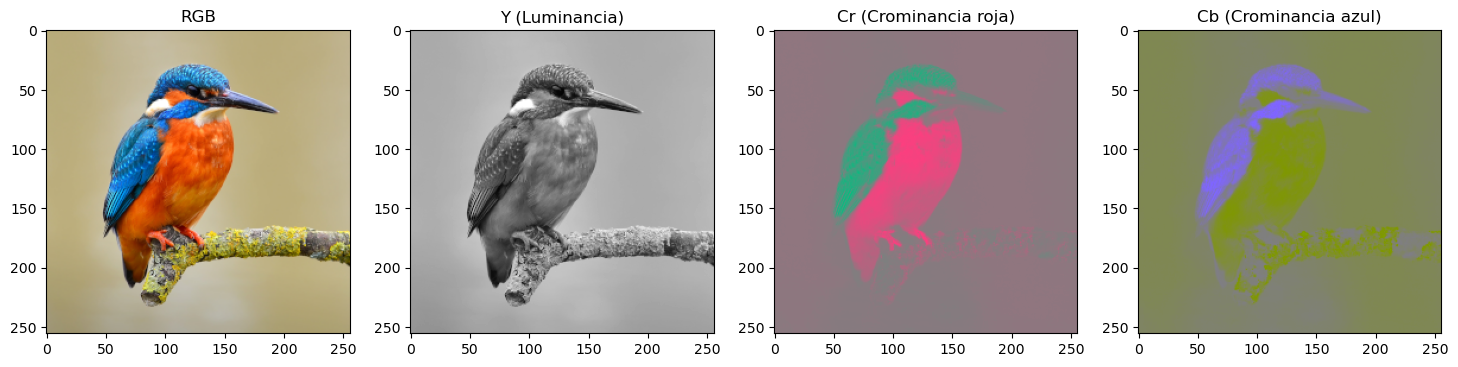

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from dahuffman import HuffmanCodec
import sys
import math
from common import *


# Esta funcion recibe el nombre de una imagen y la 
# carga en memoria. Despues obtiene las versiones
# RGB y YCrCb (OJO que en OpenCV no es YCbCr)
def load_image_RGB_to_YCrCb(image_name):
    # Cargar una imagen en formato RGB
    image = cv2.imread(image_name)

    # Pasamos de formato BGR a RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convertir de RGB a YCrCb
    image_ycrcb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
    
    return image_rgb, image_ycrcb

# Seleccionamos una imagen de ejemplo
image_bird_name = 'img_bird.png'
image_book_name = 'img_book.png'

selected_image = image_bird_name
  
# Leemos la imagen de ejemplo y obtenemos su versiones RGB y YCrCb
image_rgb, image_ycrcb = load_image_RGB_to_YCrCb(selected_image)
    
# Guardamos en una variable diferente cada una de las componentes Y, Cr y Cb.
image_y_original  = image_ycrcb[:, :, 0]
image_cr_original = image_ycrcb[:, :, 1]
image_cb_original = image_ycrcb[:, :, 2]

# Visualizar las imágenes
plt.figure(figsize=(18,10)) # Tamano de la figura
plt.subplot(141), plt.imshow(image_rgb), plt.title('RGB') # Plot de la imagen RGB

# Plot de las componentes. Observa como usamos un mapa de color diferente para cada una.
plt.subplot(142), plt.imshow(image_y_original, cmap='gray', vmax=255, vmin=0), plt.title('Y (Luminancia)')
plt.subplot(143), plt.imshow(image_cr_original, cmap=cr_map, vmin=0, vmax=255), plt.title('Cr (Crominancia roja)')
plt.subplot(144), plt.imshow(image_cb_original, cmap=cb_map, vmin=0, vmax=255), plt.title('Cb (Crominancia azul)')
plt.show()

## Downsampling de crominancias

Una vez que disponemos de las componentes de crominancia separadas de la de luminancia, podemos reducir su tamaño y así rebajar el tamaño final de la imagen si afectar demasiado a la calidad final observada por el usuario. Esta redución se hace mediante el proceso de *downsampling*, que consiste en seleccionar solo algunos pixeles de la imagen. En la siguiente figura se pueden ver los modos admitidos:

![Ejemplo subsampling](./images/chroma-subsampling-ratio-examples.png)

Cada uno de los modos hace que las componentes de crominancia reduzcan su resolución horizontal, vertical o ambas, ya que por cada grupo de 8 pixeles se seleccionan solo 2 o 4.

### Ejercicio 2

En el siguiente código aplicaremos uno de los modos de downsampling a las componentes de crominancia de la imagen. Para ello lo que haremos sera crear copias de las componentes originales en las que solo selecionamos la mitad de los pixeles horizontales o verticales dependiendo del modo del que se trate. Así, con el modo *4:2:0* reducimos a la mitad la resolución horizontal y la vertical, con el modo *4:2:2* reducimos a la mitad solo la resolución horizontal, y con el modo *4:1:1* reducimos a un cuarto la resolución horizontal. Con el modo *4:4:4* no estaríamos efectuando ningún *downsampling* y las matrices permanecerían igual.

Completa el código en la secciones que faltan, y comprueba como las imágenes efectivamente se escalan de acuerdo a la definición de los diferentes modos. Observa que para trabajar con matrices en *NumPy* se puede usar el símbolo *:* para seleccionar todos los valores en una dimensión de la matriz. Por ejemplo con $mat\left[:, 2\right]$ estaríamos seleccionado todas las filas de la matriz, pero solo los valores de la columna 2. También podemos indicar un rango en la selección. Por ejemplo $mat\left[1:10:3,:\right]$ seleccionaríá todas las columnas de la matriz, pero solo las filas que están en los indices 1,4,7 y 10.

**Cuestion 2.1**: Si usamos el modo de subsampling *4:4:4*,¿Estaremos perdiendo algo de información? ¿Qué porcentaje de la imagen original?

**Cuestion 2.2**: Si usamos el modo de subsampling *4:2:0*,¿Estaremos perdiendo algo de información? ¿Qué porcentaje de la imagen original?

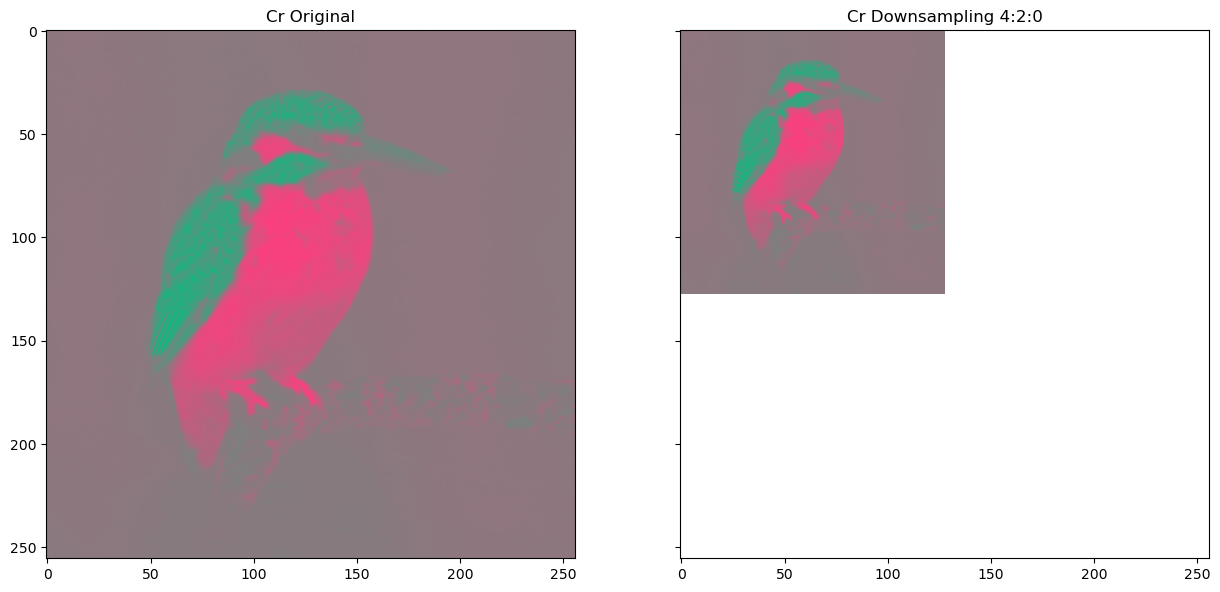

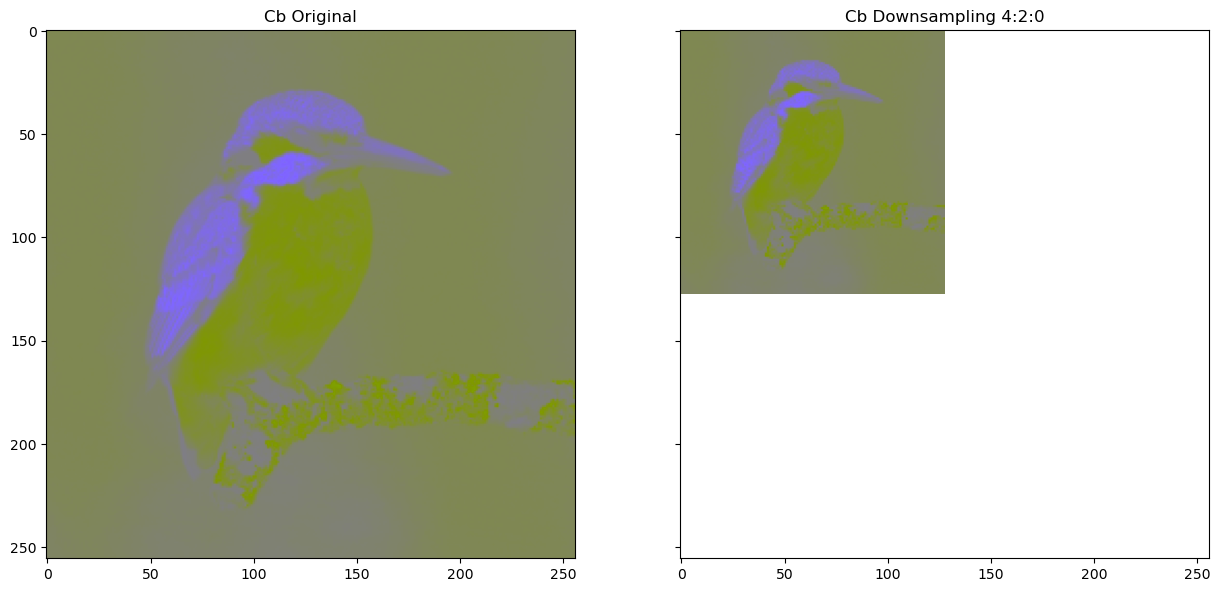

In [8]:
# Realiza un subsampling segun la opcion: 4:2:0, 4:1:1, 4:2:2, o 4:4:4
def subsampling(image, subsampling_option):
    if subsampling_option == "4:2:0":
        return image[::2, ::2]
    elif subsampling_option == "4:1:1":
        return image[:, ::4]
    elif subsampling_option == "4:2:2":
        return image[:, ::2]
    elif subsampling_option == "4:4:4":
      return image
    else:
        return image[:, :]

# Seleccionamos el modo de subsampling
subsampling_option = "4:2:0" 
image_cr = subsampling(image_cr_original, subsampling_option)
image_cb = subsampling(image_cb_original, subsampling_option)

# Hacemos un plot de las figuras. Usamos las propiedades sharex y sharey
# para mostrar dos lienzos del mismo tamano, y ver asi la diferencia de
# escala tras hacer el downsampling.

# Componente Cr
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex=True, sharey=True)
ax[1].set_title(f'Cr Downsampling {subsampling_option}')
ax[0].set_title('Cr Original')
ax[1].imshow(image_cr, cmap=cr_map, vmin=0, vmax=255)
ax[0].imshow(image_cr_original, cmap=cr_map, vmin=0, vmax=255)

# Componente Cb
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex=True, sharey=True)
ax[1].set_title(f'Cb Downsampling {subsampling_option}')
ax[0].set_title('Cb Original')
ax[1].imshow(image_cb, cmap=cb_map, vmin=0, vmax=255)
ax[0].imshow(image_cb_original, cmap=cb_map, vmin=0, vmax=255)


Para comprobar como el submuestreo de crominancias apenas afecta al resultado final que perciben nuestros ojos, vamos a realizar un submuestreo 4:2:0 de las crominancias y después recompondremos la imagen. Posteriormente, haremos lo mismo pero submuestreando la componente Y.

### Ejercicio 3

Completa el código del bloque siguiente. La salida debe ser un plot de la imagen original RGB, de la imagen con las crominancias submuestreadas, y de la imagen con la componente de luminancia submuestreada.

**Cuestion 3.1**: ¿Qué puedes decir acerca de las dos imágenes obtenidas tras el submuestreo? ¿A qué es debido?

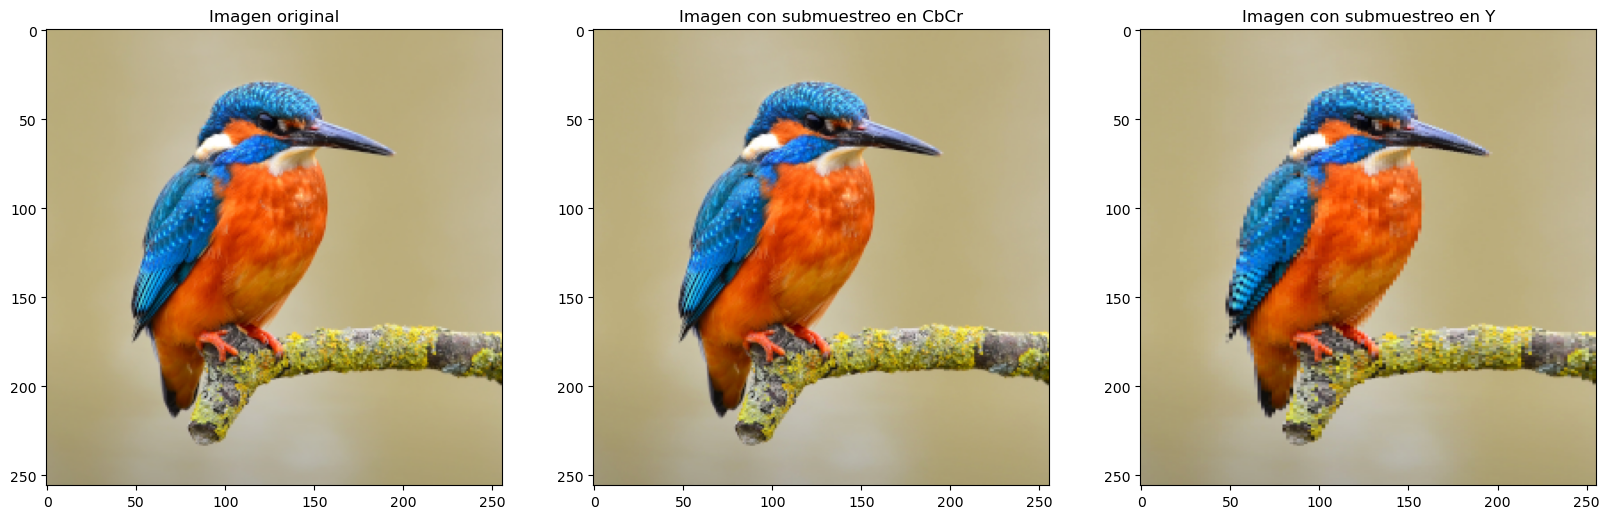

In [9]:
subsampling_option = "4:2:2"

# Submuestreo de crominancias Cr y Cb
image_cr_sub = subsampling(image_cr_original, subsampling_option)
image_cb_sub = subsampling(image_cb_original, subsampling_option)

# Cambiamos el tamano de las imagenes que sufrieron el subsampling   
reconstructed_image_cr = cv2.resize(image_cr_sub, (256, 256), interpolation=cv2.INTER_NEAREST_EXACT)
reconstructed_image_cb = cv2.resize(image_cb_sub, (256, 256), interpolation=cv2.INTER_NEAREST_EXACT)

# Reconstruimos la imagen asignandole los 3 componentes
reconstructed_rgb_sub_crcb = image_ycrcb.copy()
reconstructed_rgb_sub_crcb[..., 0] = image_y_original
reconstructed_rgb_sub_crcb[..., 1] = image_cr_original
reconstructed_rgb_sub_crcb[..., 2] = image_cb_original
reconstructed_rgb_sub_crcb = cv2.cvtColor(reconstructed_rgb_sub_crcb, cv2.COLOR_YCrCb2RGB)


# Submuestreo de la componente de luminancia Y
image_y_sub = subsampling(image_y_original, subsampling_option)

# Cambiamos el tamano de la imagen que sufrio el subsampling   
reconstructed_image_y = cv2.resize(image_y_sub, (256, 256), interpolation=cv2.INTER_NEAREST_EXACT)

# Reconstruimos la imagen asignandole los 3 componentes
reconstructed_rgb_sub_y = image_ycrcb.copy()
reconstructed_rgb_sub_y[..., 0] = reconstructed_image_y
reconstructed_rgb_sub_y[..., 1] = reconstructed_image_cr
reconstructed_rgb_sub_y[..., 2] = reconstructed_image_cb
reconstructed_rgb_sub_y = cv2.cvtColor(reconstructed_rgb_sub_y, cv2.COLOR_YCrCb2RGB)

# Hacemos un plot para comparar las imagenes
plt.figure(figsize=(20, 8))
plt.subplot(131), plt.imshow(image_rgb), plt.title('Imagen original')
plt.subplot(132), plt.imshow(reconstructed_rgb_sub_crcb), plt.title('Imagen con submuestreo en CbCr')
plt.subplot(133), plt.imshow(reconstructed_rgb_sub_y), plt.title('Imagen con submuestreo en Y')
plt.show()


## Separación en bloques

Tras el submuestreo de crominancias, el algoritmo de compresión JPEG divide cada una de las componentes *YCbCr* en bloques de $8 \times 8$ pixels, ya que serán estos bloques a los que se aplicará posteriormente la DCT. A modo de ejemplo vamos a seleccionar uno de estos bloques de la componente Y de luminancia. Ejecuta la siguiente celda de código para seleccionar el bloque. Observa a la salida los valores de cada pixel, con valores entre 0 y 255. Sustituye los valores de $x$ e $y$ para escoger el bloque de la zona que quieras.

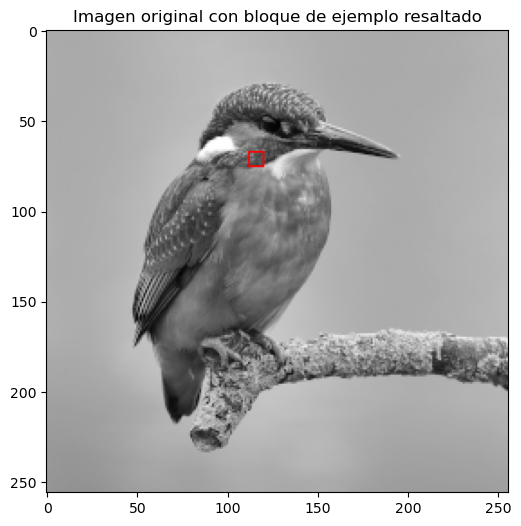

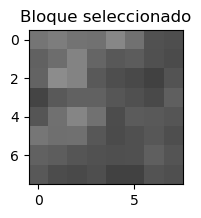

Matriz Y con los valores del bloque =

[[117 125 115 113 135 114  82  78]
 [ 97 109 132 101  88  92  80  75]
 [ 99 140 132  89  78  74  66  83]
 [ 68  90  98  98  86  80  74  95]
 [ 85 112 133 113  76  91  89  85]
 [118 111 112  87  75  80  87  78]
 [ 98  93  85  82  79  80  95  84]
 [ 88  76  74  78  65  66  83  79]]


In [10]:
# Obtener un bloque de ejemplo de la imagen Y (x e y son las coordenadas en pixels)
x=112
y=67

block = image_y_original[y:y+8, x:x+8]

# Dibujar un rectángulo en la imagen original para resaltar el bloque
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY,)
image_gray_in_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
cv2.rectangle(image_gray_in_rgb, (x, y), (x + 8, y + 8), (255, 0, 0), 1)

# Visualizar la imagen original con el rectángulo
plt.figure(figsize=(6, 6))
plt.imshow(image_gray_in_rgb)
plt.title('Imagen original con bloque de ejemplo resaltado')
plt.show()

# Visualizar la imagen del bloque seleccionado
plt.figure(figsize=(2, 2))
plt.imshow(block, cmap='gray', vmax=255, vmin=0)
plt.title('Bloque seleccionado')
plt.show()

print("Matriz Y con los valores del bloque =\n")
print(block)

El siguiente paso en el estandar es el de centrar estos valores, para que en lugar de tomar valores entre 0 y 255, lo haga entre -128 y 127. Para ello solo hace falta restar 128 a los valores de la anterior matriz. Ejecuta la siguiente celda de código para centrar los valores de la matriz $Y$ y obtener una nueva matriz que llamaremos $s$. Observa como utilizamos la función ```astype(int)``` para interpretar los datos como un entero con signo, ya que de lo contrario el valor por defecto (*uint8*) no nos permitiría almacenar valores negativos. 

Ejecuta el siguiente bloque de código y comprueba que los valores de los pixels están ahora en el rango -128 a 127.

In [11]:
# Centramos los valores de ejemplo
block_centered = block.astype(int) - 128

print("Matriz s con los valores ya centrados = \n")
print(block_centered)

Matriz s con los valores ya centrados = 

[[-11  -3 -13 -15   7 -14 -46 -50]
 [-31 -19   4 -27 -40 -36 -48 -53]
 [-29  12   4 -39 -50 -54 -62 -45]
 [-60 -38 -30 -30 -42 -48 -54 -33]
 [-43 -16   5 -15 -52 -37 -39 -43]
 [-10 -17 -16 -41 -53 -48 -41 -50]
 [-30 -35 -43 -46 -49 -48 -33 -44]
 [-40 -52 -54 -50 -63 -62 -45 -49]]


# DCT

El siguiente paso en el proceso de codificación es efectuar la transformada del coseno discreto (DCT). Esta transformación se debe realizar por cada bloque de $8 \times 8$ en los que se divide la imagen. A la matriz resultante le llamaremos $S$. La DCT, tal y como aparece definida en el estándar JPEG se calcula como

$$
	S_{u,v} = \frac{1}{4} C_u C_v \sum_{x=0}^{7} \sum_{y=0}^{7} s_{x,y}
	               \cos \left( \frac{\pi (2x + 1) u}{16} \right)
	               \cos \left( \frac{\pi (2y + 1) v}{16} \right)
$$

donde $s_{xy} \in \mathbb{R}$ es el elemento de la fila $x$, columna $y$ de la matriz $s$, con $0 \le x \le 7$, $0 \le y \le 7$; $S_{u,v} \in \mathbb{R}$ es el elemento de la fila $u$, columna $v$ de la matriz $S \in \mathbb{R}^{8 \times 8}$ de coeficientes de la DCT, con $0 \le u \le 7$, $0 \le v \le 7$; y $C_u$ y $C_v$ se definen como

$$
	C_u, C_v =
	\begin{cases}
		1/\sqrt{2}, \quad u, v = 0\\
		1, \quad \text{en otro caso}
	\end{cases}
$$

Aunque podríamos implementar esta expresión directamente, existe otra forma alternativa de obtener la DCT que reduce los cálculos a una multiplicación de matrices. La expresión sería:

$$
    S = U\cdot s \cdot U^T
$$

donde $S$ es la matriz con los valores de la DCT de $s$, y $U$ es una matriz ortonormal con los siguientes valores:

$$
U=\frac{1}{2}\left[\begin{array}{cccccccc}\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} \\ \cos \frac{\pi}{16} & \cos \frac{3 \pi}{16} & \cos \frac{5 \pi}{16} & \cos \frac{7 \pi}{16} & \cos \frac{9 \pi}{16} & \cos \frac{11 \pi}{16} & \cos \frac{13 \pi}{16} & \cos \frac{15 \pi}{16} \\ \cos \frac{2 \pi}{16} & \cos \frac{6 \pi}{16} & \cos \frac{10 \pi}{16} & \cos \frac{14 \pi}{16} & \cos \frac{18 \pi}{16} & \cos \frac{22 \pi}{16} & \cos \frac{26 \pi}{16} & \cos \frac{30 \pi}{16} \\ \cos \frac{3 \pi}{16} & \cos \frac{9 \pi}{16} & \cos \frac{15 \pi}{16} & \cos \frac{21 \pi}{16} & \cos \frac{27 \pi}{16} & \cos \frac{33 \pi}{16} & \cos \frac{39 \pi}{16} & \cos \frac{45 \pi}{16} \\ \cos \frac{4 \pi}{16} & \cos \frac{12 \pi}{16} & \cos \frac{20 \pi}{16} & \cos \frac{28 \pi}{16} & \cos \frac{36 \pi}{16} & \cos \frac{44 \pi}{16} & \cos \frac{52 \pi}{16} & \cos \frac{60 \pi}{16} \\ \cos \frac{5 \pi}{16} & \cos \frac{15 \pi}{16} & \cos \frac{25 \pi}{16} & \cos \frac{35 \pi}{16} & \cos \frac{45 \pi}{16} & \cos \frac{55 \pi}{16} & \cos \frac{65 \pi}{16} & \cos \frac{75 \pi}{16} \\ \cos \frac{6 \pi}{16} & \cos \frac{18 \pi}{16} & \cos \frac{30 \pi}{16} & \cos \frac{42 \pi}{16} & \cos \frac{54 \pi}{16} & \cos \frac{66 \pi}{16} & \cos \frac{78 \pi}{16} & \cos \frac{90 \pi}{16} \\ \cos \frac{7 \pi}{16} & \cos \frac{21 \pi}{16} & \cos \frac{35 \pi}{16} & \cos \frac{49 \pi}{16} & \cos \frac{63 \pi}{16} & \cos \frac{77 \pi}{16} & \cos \frac{91 \pi}{16} & \cos \frac{105 \pi}{16}\end{array}\right]
$$

Usando esta matriz, hacer la DCT a una matriz de pixels $s$ es tan sencillo como hacer una multiplicación de matrices.

### Ejercicio 4

*NumPy* ofrece múltiples herramientas para trabajar con matrices. La multiplicación de matrices se realiza con el operador ```dot()```, que recibe como parámetros las matrices a multiplicar. Y para obtener la matriz traspuesta de otra es tan sencillo como acceder a su propiedad ```.T``` (siempre que la matriz sea un ```np.array```).

Completa los fragmentos que faltan en el siguiente bloque de código. A su salida, debería verse una gráfica con los pixels del bloque original y otra con los valores de la *DCT*, calculada con el producto de matrices descrito anteriormente. Utiliza el bloque de $8 \times 8$ pixels de ejemplo, con los valores centrados entre -128 y 127. Observa como en este caso los valores de la *DCT* son números flotantes, al contrario que los valores de los pixels originales que eran enteros.

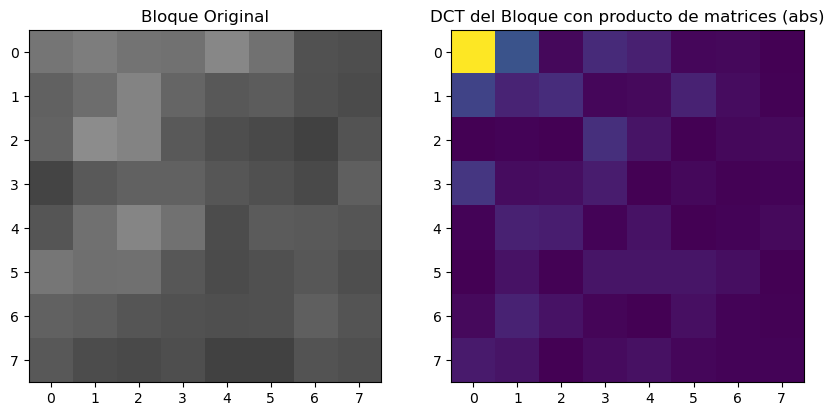


Valores de la DCT:

[[-281.5    71.75   -5.73  -33.42  -25.     -4.93    6.43    0.54]
 [  56.28   28.24  -35.88   -4.78   -7.46  -27.37    9.5     1.15]
 [  -0.19   -2.79    0.72   37.86   15.13    1.07   -6.34    7.59]
 [  44.07    8.95  -10.61   21.67   -0.74    6.39    1.53    3.17]
 [  -2.25  -26.11  -22.23    2.63   14.25   -0.43   -2.7    -7.41]
 [  -0.52  -14.04    1.35   16.13   16.26  -15.9   -10.38    0.2 ]
 [   7.38   27.26   13.41    3.44   -0.05  -11.44   -2.47    1.79]
 [  20.03   14.39   -0.79   -7.89  -12.88   -5.41   -3.15   -3.01]]


In [12]:
# Genera la matriz U descrita en la seccion anterior
def generate_u():
    u_matrix = np.zeros((8, 8)).astype(np.float32)
    colIncrement = 2
    u_matrix[0, :] = np.sqrt(2) / 4
    for rowIndex in range(1, 8):
        factor = rowIndex
        for colIndex in range(8):
            u_matrix[rowIndex, colIndex] = 0.5 * np.cos(factor * np.pi / 16)
            factor += colIncrement
        colIncrement += 2
    return u_matrix

# Funcion que calcula la DCT de un bloque de 8x8 usando multiplicacion matricial
def do_dct(a_block):
    u_matrix = generate_u()
    return np.dot(u_matrix, np.dot(a_block, np.transpose(u_matrix)))

# Calculamos la DCT
dct_block = do_dct(block_centered)

# Visualizamos el bloque original y su DCT
# Pintamos el valor absoluto de los coeficientes de la DCT para que en el 
# grafico salga mas claro cuales son los coeficientes con una magnitud mayor
plt.figure(figsize=(10, 6))
plt.subplot(121), plt.imshow(block, cmap='gray', vmax=255, vmin=0), plt.title('Bloque Original')
plt.subplot(122), plt.imshow(abs(dct_block), cmap='viridis'), plt.title('DCT del Bloque con producto de matrices (abs)')
plt.show()

np.set_printoptions(suppress=True, precision=2)

print("\nValores de la DCT:\n")
print(dct_block.astype(float))

### DCT inversa de un bloque

Tras hacer la *DCT* de un bloque, podemos usar la *DCT* inversa (*IDCT*) para transformar sus valores en los valores de los pixels originales. Esta operación se define en el estandar como:

$$
	s_{x,y} = \frac{1}{4} \sum_{u=0}^{7} \sum_{v=0}^{7} C_u C_v S_{u,v}
	               \cos \left( \frac{\pi (2x + 1) u}{16} \right)
	               \cos \left( \frac{\pi (2y + 1) v}{16} \right)
$$

Pero de nuevo, al igual que para hacer la DCT, existe una forma alternativa de calcular la DCT inversa utilizando una simple multiplicación de matrices. Para ello se usa la siguiente expresión:

$$
    s = U^T\cdot S \cdot U
$$


donde $S$ es la matriz con los valores de la DCT, $s$ es la matriz con los pixels recuperados, y $U$ es la matriz ortonormal definida anteriormente.

### Ejercicio 5

Completa los fragmentos que faltan en el bloque de código siguiente. A la salida del mismo, debe mostrarse un plot con los pixels del bloque de ejemplo original, un plot con la DCT de ese bloque, y otro plot con los pixels de la IDCT usando la multiplicación de matrices. Ten en cuenta que debes volver a poner los valores de las imágenes de salida en el rango $[0,255]$ para que el plot coincida con el de la imagen original. También debe mostrarse un *print* con los valores del bloque original y los de la IDCT.

**Cuestión 5.1**: ¿Observas alguna diferencia entre los valores del bloque original y los valores recuperados mediante la IDCT? ¿Qué significa eso con respecto a la DCT?

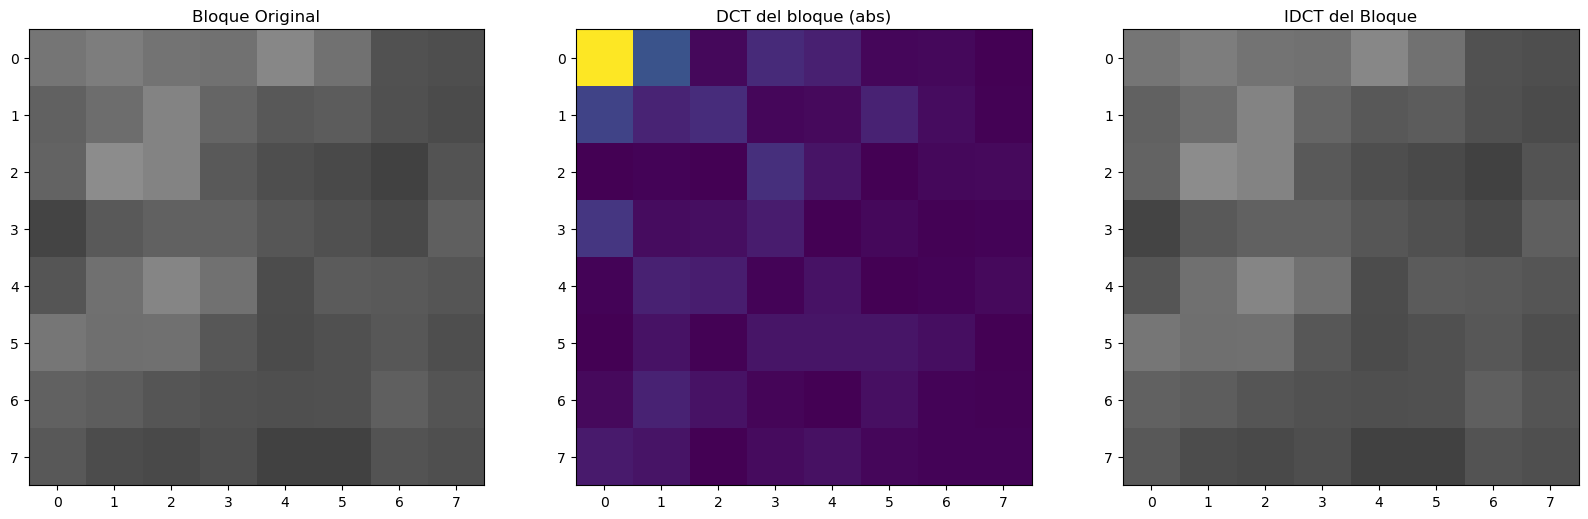

Bloque original:

[[117 125 115 113 135 114  82  78]
 [ 97 109 132 101  88  92  80  75]
 [ 99 140 132  89  78  74  66  83]
 [ 68  90  98  98  86  80  74  95]
 [ 85 112 133 113  76  91  89  85]
 [118 111 112  87  75  80  87  78]
 [ 98  93  85  82  79  80  95  84]
 [ 88  76  74  78  65  66  83  79]]

Bloque recuperado con la IDCT:

[[117 125 115 113 135 114  82  78]
 [ 97 109 132 101  88  92  80  75]
 [ 99 140 132  89  78  74  66  83]
 [ 68  90  98  98  86  80  74  95]
 [ 85 112 133 113  76  91  89  85]
 [118 111 112  87  75  80  87  78]
 [ 98  93  85  82  79  80  95  84]
 [ 88  76  74  78  65  66  83  79]]


In [13]:
# Funcion que calcula la IDCT usando multiplicacion matricial
def idct_mult_mat(a_dct_block):
    u_matrix = generate_u()
    return np.round(np.dot(np.transpose(u_matrix),np.dot(a_dct_block,u_matrix)))

# Creamos la IDCT del bloque de ejemplo
idct_block = idct_mult_mat(dct_block)

# Volvemos a colocar el rango de intensidad en [0, 255]
idct_block = idct_block.astype(int) + 128

# Visualizamos el bloque original, su DCT y su IDCT
plt.figure(figsize=(20, 8))
plt.subplot(131), plt.imshow(block, cmap='gray',vmax = 255,vmin = 0), plt.title('Bloque Original')
plt.subplot(132), plt.imshow(abs(dct_block), cmap='viridis'), plt.title('DCT del bloque (abs)')
plt.subplot(133), plt.imshow(idct_block, cmap='gray',vmax = 255,vmin = 0), plt.title('IDCT del Bloque')
plt.show()


print('Bloque original:\n')
print(block)

print('\nBloque recuperado con la IDCT:\n')
print(idct_block)

## Cuantificación de un bloque

En este paso la matriz de coeficientes de la *DCT* $S$ se divide elemento a elemento por la matriz de cuantificación, y luego se redondean los elementos resultantes. El objetivo de este paso es reducir la resolución de los coeficientes de la *DCT* para poder representarlos con un menor número de bits. Los coeficientes de la matriz de cuantificación típicamente se diseñan de forma que las componentes de frecuencias bajas sean valores bajos (mayor resolución), y que las componentes de las frecuencias altas sean valores altos (menor resolución). El estándar JPEG  permite al codificador definir la matriz de cuantificación como desee, pero también proporciona en su anexo K.1 la siguiente matriz de cuantificación de ejemplo que es típicamente usada:

$$
Q =
\begin{bmatrix}
    16 & 11 & 10 & 16 &  24 &  40 &  51 &  61\\
    12 & 12 & 14 & 19 &  26 &  58 &  60 &  55\\
    14 & 13 & 16 & 24 &  40 &  57 &  69 &  56\\
    14 & 17 & 22 & 29 &  51 &  87 &  80 &  62\\
    18 & 22 & 37 & 56 &  68 & 109 & 103 &  77\\
    24 & 35 & 55 & 64 &  81 & 104 & 113 &  92\\
    49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
    72 & 92 & 95 & 98 & 112 & 100 & 103 &  99
\end{bmatrix}
$$

Para obtener la salida de este paso, por tanto, se deben dividir elemento a elemento los coeficientes de $S$ por los coeficientes de $Q$ y redondear.

$$
K=\lfloor \frac{S}{Q} \rceil
$$

donde $K$ es la matriz con los valores de la *DCT* cuantificados, $S$ es la matriz con los coeficientes de la *DCT* originales, y $Q$ es la matriz de cuantificación. En JPEG se puede definir el nivel de calidad a la hora de codificar una imagen, y este nivel de calidad está precisamente relacionado con la matriz de cuantificación. Así, según el nivel de calidad, se realizará un escalado de la matriz de cuantificación. Cuanto mayor sea el escalado, mayores serán los valores de la matriz de cuantificación y por tanto, la división final dará unos valores mucho mas pequeños en la matriz de la DCT cuantificada. En el nivel máximo de calidad, la matriz de cuantificación se vuelve una matriz con solo unos, de forma que los valores de la *DCT* permanecen inalterados.

### Ejercicio 6

Para realizar el paso de cuantificación solo necesitamos dividir los valores de la *DCT* por los valores de la matriz de cuantificación $Q$. Dependiendo del factor de escalado de dicha matriz sus valores serán mayores o menores, de forma que al hacer la división y redondear apareceran un número de ceros diferente en la matriz cuantificada $K$.

Completa el código siguiente, donde se realiza la cuantificación del bloque de ejemplo usando tres factores de cuantificación diferentes: $1$, $0.25$ y $4$. A la salida de esta celda debería mostrarse una gráfica con la *DCT* original del bloque, y otra para cada una de las versiones cuantificadas. También debería salir un texto en el que aparezca el numero de valores diferentes de cero en cada uno de los casos. A la hora de pintar los valores de las matrices cuantificadas, hazlo del valor absoluto de los valores. De esta forma se verán mejor los valores diferentes de cero en la gráfica. Además, usa el mapa de color ```cmap_black_zero``` para pintar las versiones cuantificadas de la *DCT*, ya que así los valores que se redondearon a $0$ tras el proceso aparecerán pintados de negro.

**Cuestion 6.1**: Anota los valores de salida. A la vista de ellos, ¿Con qué nivel de cuantificación se consigue un **mayor** número de valores en la matriz $K$? ¿A qué es debido?

**Cuestion 6.2**: ¿Por qué se vuelven nulos algunos valores de las matrices cuantificadas pero no otros?

In [14]:
# Definimos la matriz de cuantificación
quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                    [12, 12, 14, 19, 26, 58, 60, 55],
                                    [14, 13, 16, 24, 40, 57, 69, 56],
                                    [14, 17, 22, 29, 51, 87, 80, 62],
                                    [18, 22, 37, 56, 68, 109, 103, 77],
                                    [24, 35, 55, 64, 81, 104, 113, 92],
                                    [49, 64, 78, 87, 103, 121, 120, 101],
                                    [72, 92, 95, 98, 112, 100, 103, 99]]).astype(np.float32)

# Esta funcion recibe un bloque con valores de la DCT y devuelve
# otra matriz con los valores escalados. Para ello recibe tambien
# como parametros la matriz de cuantificacion y el factor de escalado
# de esta
def quantizy_block(the_dct_block, quantization_matrix, scale_factor):
    if scale_factor==0:
        quantization_matrix=np.ones((8,8)).astype(np.float32)
        scale_factor=1
    
    scaled_quantization_matrix = np.float32(%%%%%%%% COMPLETAR %%%%%%%%%%)
    # Hacemos la division usando np.divide, para evitar divir por cero en caso de 
    # que la funcion reciba una matriz de cuantificacion con ceros
    return np.round(np.divide(%%%%%%%% COMPLETAR %%%%%%%%%%, %%%%%%%% COMPLETAR %%%%%%%%%%, out=np.zeros_like(the_dct_block), where=scaled_quantization_matrix!=0)).astype(int)
    

# Calculamos la matriz cuantificada para cada valor de escalado
quantized_block = quantizy_block(dct_block,quantization_matrix,1)
quantized_block_025 = %%%%%%%% COMPLETAR %%%%%%%%%%
quantized_block_4 = %%%%%%%% COMPLETAR %%%%%%%%%%

# Creamos un mapa de color para que los valores 0 dela DCT se pinten de negro
cmap_black_zero = plt.colormaps["viridis"].copy()
cmap_black_zero.set_under('black')

# Visualizamos el bloque con la DCT original y las versiones cuantificadas
plt.figure(figsize=(12, 12))
plt.subplot(221), plt.imshow(np.abs(dct_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT original')
plt.subplot(222), plt.imshow(np.abs(quantized_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT cuantificado escala 1')
plt.subplot(223), plt.imshow(np.abs(quantized_block_025), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT cuantificado escala 0.25')
plt.subplot(224), plt.imshow(np.abs(quantized_block_4), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT cuantificado escala 4')
plt.show()

# Imprimimos los valores diferentes de cero de cada matriz
print(f'Valores no nulos en la DCT original: {(dct_block!=0).sum()}')
print(f'Valores no nulos en la DCT cuantificada escala 1: {(quantized_block!=0).sum()}')
print(f'Valores no nulos en la DCT cuantificada escala 0.25: {(quantized_block_025!=0).sum()}')
print(f'Valores no nulos en la DCT cuantificada escala 4: {(quantized_block_4!=0).sum()}')


SyntaxError: invalid syntax (2485099059.py, line 20)

### Deshacer la cuantificación de un bloque

Para deshacer el proceso de cuantificación, simplemente se necesita volver a multiplicar la matriz cuantificada $K$ por la matriz de cuantificación original $Q$. Es por eso que dichas matrices (las de las componentes $Y$ y las de las componentes $Cb$, $Cr$) se guardan en el fichero JPEG final. En caso de haber utilizado un factor de escalado sobre la matriz de cuantificación es necesario que eso se vea reflejado en las matrices finales guardadas en el JPEG.

Es importante recordar que la cuantificación es un proceso destructivo, ya que al usar la operación de redondeo hay muchos coeficientes que se convertiran en $0$, lo que hará imposible recuperar su valor original.

### Ejercicio 7

Completa el bloque de código siguiente para implementar la función que permite deshacer el efecto de la cuantificación y volver a obtener los valores de la *DCT* original (menos las diferencias provocadas por el redondeo).

A la salida del bloque se deben mostrar 3 filas con 3 gráficas en cada una de ellas. En cada fila se mostrará la *DCT* del bloque de ejemplo, la versión cuantificada de dicha matriz, y la versión recuperada. Cada fila usará los factores de escalado anteriores, $1$, $0.25$ y $4$.

**Cuestión 7.1**: ¿Los valores recuperados diferentes de cero, tienen el mismo valor que en la *DCT* original? ¿Por qué?

In [ ]:
def unquantizy_block(the_quantized_block, quantization_matrix, scale_factor):
    if scale_factor==0:
        quantization_matrix=np.ones((8,8)).astype(np.float32)
        scale_factor=1
    return %%%%%%%% COMPLETAR %%%%%%%%%%


unquantized_block = %%%%%%%% COMPLETAR %%%%%%%%%%
unquantized_block_025 = %%%%%%%% COMPLETAR %%%%%%%%%%
unquantized_block_4 = %%%%%%%% COMPLETAR %%%%%%%%%%


plt.figure(figsize=(12, 12))
# Visualizar el bloque original y su DCT
plt.subplot(331), plt.imshow(np.abs(dct_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT original')
plt.subplot(332), plt.imshow(np.abs(quantized_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT cuantificado escala 1')
plt.subplot(333), plt.imshow(np.abs(unquantized_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT recuperado escala 1')

plt.subplot(334), plt.imshow(np.abs(dct_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT original')
plt.subplot(335), plt.imshow(np.abs(quantized_block_025), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT cuantificado escala 0.25')
plt.subplot(336), plt.imshow(np.abs(unquantized_block_025), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT recuperado escala 0.25')

plt.subplot(337), plt.imshow(np.abs(dct_block), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT original')
plt.subplot(338), plt.imshow(np.abs(quantized_block_4), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT cuantificado escala 4')
plt.subplot(339), plt.imshow(np.abs(unquantized_block_4), cmap=cmap_black_zero,vmax = 50,vmin = 0.001), plt.title('Bloque DCT recuperado escala 4')

plt.show()


### DCT de una imagen completa

A continuación calcularemos la *DCT* de la imagen correspondiente a la imagen $Y$ completa. Para ello solo es necesario recorrer todos los bloque de $8 \times 8$ de la imagen y aplicar la función *DCT* que creamos anteriormente a cada uno de ellos.

### Ejercicio 8

Completa el código que aparece a continuación. La salida debe ser un plot de la imagen original (en escala de grises) y a su lado los coeficientes de la *DCT* correspondientes a todos los bloques de la imagen. Para que en la imagen sea mas facil ver los valores mas lejanos de cero, pinta el valor absoluto de los valores.

**Cuestión 8.1**: A la vista de las dos imágenes, ¿Ves alguna similitudes entre ambas? ¿A qué es debido?

In [ ]:
# Calcula la DCT de una imagen
# Recorre todos los bloques de 8x8 de la imagen y les 
# aplica a cada uno la funcion que calcula la DCT
def dct_of_image(the_image):
    result = np.zeros_like(the_image, dtype=np.float32)
    block_size = 8
    height, width = the_image.shape[:2]
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = the_image[i:i+block_size, j:j+block_size]
            %%%%%%%% COMPLETAR %%%%%%%%%%
            result[i:i+block_size, j:j+block_size] = %%%%%%%% COMPLETAR %%%%%%%%%%
    return result
    
# Centramos los valores de los pixeles entre -128 y 127
centered_image_y = %%%%%%%% COMPLETAR %%%%%%%%%%

# Calculamos la DCT de todos los bloques de la iamgen
dct_image_y = dct_of_image(centered_image_y)

# Visualizar la imagen original
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_y_original, cmap='gray', vmax=255, vmin=0)
plt.title('Imagen Original, Componente Y')

# Visualizar la imagen con valores DCT
plt.subplot(1, 2, 2)
plt.imshow(np.abs(dct_image_y), cmap=cmap_black_zero,vmax = 50,vmin = 0.001)
plt.title('Valores DCT (abs)')
plt.show()

### La DCT y las frecuencias de la imagen

La *DCT* nos permite ver como se distribuye la energía de una imagen en las diferentes frecuencias. Así, imágenes con predominio de transiciones suaves en la intensidad de los pixels tendrán valores altos en la *DCT* en las posiciones correspondientes a las frecuencias bajas, mientras que si la imagen tiene variaciones bruscas de intensidad entonces los valores altos de la *DCT* se situarán en las posiciones correspondientes a las frecuencias altas. En la siguiente figura puede verse de forma gráfica cuales son las posiciones de la matriz *DCT* que se corresponden con las frecuencias altas y bajas. Asi, los valores cercanos a la esquina superior izquierda se corresponden con las frecuencias bajas (transiciones suaves), mientras que los cercanos a la esquina inferior derecha se corresponden con las frecuencias altas (transiciones bruscas).

<img src="./images/consine-transforms-jpeg.png" alt="Bases DCT" style="width: 35%"/>

### Ejercicio 9

Partiendo del código del anterior bloque, completa la siguiente celda para que se muestre la misma figura con la *DCT* de la componente $Y$ de una imagen, pero en este caso haz que sea la imagen ```image_book_name```.

**Cuestión 9.1**: Comparando esta imágen con la del pájaro, ¿Qué diferencias observas en cuanto al numero de coeficientes de la *DCT* con valores cercanos al cero? ¿Qué nos dice eso con respecto a la naturaleza (predominio de frecuencias altas o bajas) de cada imagen?

In [ ]:
# Cargamos la imagen de nombre image_book_name
# y obtenemos sus versiones RGB y YCrCb
image_rgb_book, image_ycrcb_book = load_image_RGB_to_YCrCb(image_book_name)

# Guardamos la componente Y en una variable
image_y_original_book  = %%%%%%%% COMPLETAR %%%%%%%%%%

# Centramos los valores de los pixeles entre -128 y 127
centered_image_y_book = %%%%%%%% COMPLETAR %%%%%%%%%%

# Aplicamos la DCT a todos los bloques de la imagen
dct_image_y_book = dct_of_image(centered_image_y_book)

# Visualizar la imagen original
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_y_original_book, cmap='gray')
plt.title('Imagen Original Libro, Componente Y')

# Visualizar la imagen con valores DCT
plt.subplot(1, 2, 2)
plt.imshow(np.abs(dct_image_y_book), cmap=cmap_black_zero,vmax = 50,vmin = 0.001)
plt.title('Valores DCT de la imagen Libro (abs)')
plt.show()

### Cuantificación de una imagen completa

A continuación vamos a hacer el proceso completo de cuantificación sobre toda la imagen correspondiente a la componente Y. Para ello solo necesitamos recorrer todos los bloques de $8 \times 8$ de la imagen y aplicarles a cada uno de ellos la funcion ```quantizy_block()``` que creamos anteriormente.

### Ejercicio 10

Completa el código siguiente. La salida debe mostrar una gráfica con los valores originales de la *DCT* y otras tres con los valores cuantificados para factores de escala $1$, $0.25$, y $4$. También debe imprimirse por pantalla el número de coeficientes no nulos de cada matriz, así como el porcentaje de estos valores de las matrices cuantificadas con respecto a la matriz original de la *DCT*.

**Cuestión 10.1**: ¿Se parecen las versiones cuantificadas entre sí? ¿Cual es la diferencia entre ellas? ¿A qué es debido?

In [ ]:
# Cuantifica todos los bloques 8x8 de una imagen
# Necesita recibir la matriz de cuantificacion y el factor de escalado
def quantizy_image(the_dct_image, quantization_matrix, scale_factor):
    result = np.zeros_like(the_dct_image)
    height, width = the_dct_image.shape[:2]
    block_size = 8
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            dct_block = the_dct_image[i:i+block_size, j:j+block_size]
            quantized_block = %%%%%%%% COMPLETAR %%%%%%%%%%
            result[i:i+block_size, j:j+block_size] = %%%%%%%% COMPLETAR %%%%%%%%%%
    
    return result


# Calculamos las matrices cuantificadas con diferentes escalas
quantized_y = quantizy_image(dct_image_y, quantization_matrix, 1)
quantized_y_025 = quantizy_image(dct_image_y, quantization_matrix, 0.25)
quantized_y_4 = quantizy_image(dct_image_y, quantization_matrix, 4)

# Visualizar la imagen con valores DCT después de la cuantificación
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(abs(dct_image_y), cmap=cmap_black_zero,vmax = 50,vmin = 0.001)
plt.title('Valores DCT componente Y')

plt.subplot(2, 2, 2)
plt.imshow(abs(quantized_y), cmap=cmap_black_zero,vmax = 50,vmin = 0.001)
plt.title('Valores DCT cuantificados Escala 1')

plt.subplot(2, 2, 3)
plt.imshow(abs(quantized_y_025), cmap=cmap_black_zero,vmax = 50,vmin = 0.001)
plt.title('Valores DCT cuantificados Escala 0.25')

plt.subplot(2, 2, 4)
plt.imshow(abs(quantized_y_4), cmap=cmap_black_zero,vmax = 50,vmin = 0.001)
plt.title('Valores DCT cuantificados Escala 4')

plt.show()

# Calculamos el numero de factores no nulos de cada imagen
coefs_count_dct_y = (dct_image_y!=0).sum()
coefs_count_dct_y_q_1 = %%%%%%%% COMPLETAR %%%%%%%%%%
coefs_count_dct_y_q_025 = %%%%%%%% COMPLETAR %%%%%%%%%%
coefs_count_dct_y_q_4 = %%%%%%%% COMPLETAR %%%%%%%%%%

print(f'Num. no nulos en la DCT original: {coefs_count_dct_y}')
print(f'Num. no nulos en la DCT cuantificada escala 1: {coefs_count_dct_y_q_1},  {coefs_count_dct_y_q_1/(coefs_count_dct_y)*100} % ')
print(f'Num. no nulos en la DCT cuantificada escala 0.25: {coefs_count_dct_y_q_025},  {coefs_count_dct_y_q_025/(coefs_count_dct_y)*100} %')
print(f'Num. no nulos en la DCT cuantificada escala 4: {coefs_count_dct_y_q_4},  {coefs_count_dct_y_q_4/(coefs_count_dct_y)*100} %')


### Deshacer la cuantificación y aplicar la IDCT a una imagen completa

Una vez que tenemos todos los valores de la DCT de la imagen cuantificados, podemos implementar las funciones que nos permitirán volver a atrás. Necesitaremos primero deshacer el efecto del cuantificado y después aplicar la IDCT a cada uno de los bloques de $8\times 8$ de la imagen.

### Ejercicio 11

Utiliza las funciones ```unquantizy_block()``` y ```idct_mult_mat``` que creamos antes para aplicarlas a todos los bloques de la imagen $Y$ del apartado anterior. La salida del bloque debería mostrar una gráfica con la imagen original Y y la versión reconstruida. Utiliza la imagen que fue cuantificada con un factor de escalado de $1$.

In [ ]:
# Deshace el efecto de la cuantificacion en todos los bloques 
# de 8x8 de uyna imagen. Debe pasarsele la misma matriz de cuantificacion
# y el mismo factor de escalado que se uso para cuantificar
def unquantizy_image(the_quantized_image, quantization_matrix, scale_factor):
    result = np.zeros_like(the_quantized_image)
    height, width = the_quantized_image.shape[:2]
    block_size = 8
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = the_quantized_image[i:i+block_size, j:j+block_size]
            unquantized_block = %%%%%%%% COMPLETAR %%%%%%%%%%
            result[i:i+block_size, j:j+block_size] = %%%%%%%% COMPLETAR %%%%%%%%%%
    
    return result


# Hace la IDCT a todos los bloques de 8x8 de una imagen
def idct_of_image(the_dct_image):
    result = np.zeros_like(the_dct_image, dtype=np.float32)
    height, width = the_dct_image.shape[:2]
    block_size = 8
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = the_dct_image[i:i+block_size, j:j+block_size]
            idct_block = %%%%%%%% COMPLETAR %%%%%%%%%%
            result[i:i+block_size, j:j+block_size] = %%%%%%%% COMPLETAR %%%%%%%%%%
    return result


# Reconstruimos la DCT de la imagen deshaciendo el efecto de la cuantificacion
reconstructed_dct = unquantizy_image(quantized_y, quantization_matrix, 1)

# Hacemos la IDCT para obtener de nuevo el valor de los pixels
reconstructed_image_y = %%%%%%%% COMPLETAR %%%%%%%%%%

# Ponemos de nuevo los pixeles entre 0 y 255
reconstructed_image_y = reconstructed_image_y.astype(int)  + 128
       
# Visualizar la imagen original
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_y_original, cmap ='gray', vmax=255, vmin=0)
plt.title('Imagen original. Componente Y.')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_y, cmap ='gray', vmax=255, vmin=0)
plt.title('Imagen reconstruida. Componente Y.')
plt.show()

### La importancia del coeficiente DC 

El componente DC o de continua es el valor de la matriz de la *DCT* de la posición $(0,0)$. Es el factor mas importante, ya que almacena la intensidad media de todos los pixels del bloque. Es tan importante que incluso en la fase de codificación entrópica, este valor se codifica de forma diferente a los demás (conocidos como coeficientes de AC).

### Ejercicio 12

Completa el código del bloque siguiente. En este apartado se usarán tres matrices de cuantificación diferentes para cuantificar los valores de la *DCT*: una que seleccione solo el valor de DC y anule el resto, otra que seleccione el valor de DC y además los coeficientes de las posiciones $(0,1)$ y $(1,0)$, y por último una matriz de cuantificación que seleccione todos los coeficientes de la *DCT* **excepto** el valor de DC y los de las posiciones $(0,1)$ y $(1,0)$.

**Cuestion 12.1**: Viendo la imagen en la que solo queda el coeficiente de DC tras la cuantificación, ¿Qué es lo que observas? ¿A qué es debido?

**Cuestion 12.2**: Observando las otras dos gráficas, ¿por qué se parece más al original la imagen con solo 3 coeficientes que la que usa 61? ¿Qué es lo que se estaría viendo realmente en esta última con respecto a las diferentes frecuencias que componen la imagen?

In [ ]:
# Esta funcion parte de la DCT de una imagen y aplica los siguientes
# pasos:
# - Cuantifica la DCT
# - Deshace el efecto de la cuantificacion
# - Aplica la IDCT para obtener los pixels originales
# - Cambia el rango de los pixels para estar en [0,255]
def reconstructs_image(a_dct_matrix, a_quantization_matrix, a_scale_factor):
    quantized_image = quantizy_image(a_dct_matrix, a_quantization_matrix, a_scale_factor)
    unquantized_image = unquantizy_image(quantized_image, a_quantization_matrix, a_scale_factor)
    reconstructed_image = idct_of_image(unquantized_image)
    reconstructed_image = reconstructed_image.astype(int)  + 128
    return reconstructed_image

# Creamos una matriz de cuantificacion para que se mantenga 
# intacto el valor de DC y se anulen el resto de coeficientes
quantization_matrix_only_dc=np.zeros((8,8))
quantization_matrix_only_dc[0,0]= 1

# Creamos una matriz de cuantificacion para que se mantengan
# intactos los coeficientes de las posiciones (0,0), (0,1) y (1,0)
# y se anulen el resto.
quantization_matrix_3_coefs=np.zeros((8,8))
quantization_matrix_3_coefs[%%%%%%%% COMPLETAR %%%%%%%%%%
quantization_matrix_3_coefs[%%%%%%%% COMPLETAR %%%%%%%%%%

# Creamos una matriz de cuantificacion que anula los coeficientes
# de las posiciones (0,0), (0,1) y (1,0) y deja intactos el resto
quantization_matrix_discard_3_coefs=np.ones((8,8))
quantization_matrix_discard_3_coefs[%%%%%%%% COMPLETAR %%%%%%%%%%
quantization_matrix_discard_3_coefs[%%%%%%%% COMPLETAR %%%%%%%%%%

# Reconstruimos las tres versiones de la imagen, cada una usando
# una matriz de cuantificacion diferente
reconstructed_image_y_only_dc = reconstructs_image(dct_image_y, quantization_matrix_only_dc, 1)
reconstructed_image_y_3_coefs = %%%%%%%% COMPLETAR %%%%%%%%%%
reconstructed_image_y_discard_3_coefs = %%%%%%%% COMPLETAR %%%%%%%%%%

# Visualiza las imagenes
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(image_y_original, cmap ='gray', vmax=255, vmin=0)
plt.title('Imagen original. Componente Y.')

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_image_y_only_dc, cmap ='gray', vmax=255, vmin=0)
plt.title('Imagen reconstruida, solo con el coeficiente de DC.')

plt.subplot(2, 2, 3)
plt.imshow(reconstructed_image_y_3_coefs, cmap ='gray', vmax=255, vmin=0)
plt.title('Imagen reconstruida, con 3 coeficientes.')

plt.subplot(2, 2, 4)
plt.imshow(reconstructed_image_y_discard_3_coefs, cmap ='gray', vmax=255, vmin=0)
plt.title('Imagen reconstruida, eliminando los 3 coeficientes de las frecuencias mas bajas.')

plt.show()

### Métrica de calidad

La $pSNR$ o *Peak Signal-to-Noise Ratio* es una medida que nos permite comparar de forma objetiva la imagen original con la imagen comprimida. Se define como:

$$
\text{pSNR} = 10 \cdot \log_{10}\left(\frac{{\text{MAX}^2}}{{\text{MSE}}}\right)
$$

donde $MAX$ es el valor máximo que puede tener un píxel (normalmente, el valor $255$), y $MSE$ es el Error Cuadrático Medio (Mean Squared Error) entre la imagen original y la imagen de referencia. Recordemos que para calcular el $MSE$ entre dos imágenes podemos usar la siguiente expresión:

$$
\text{MSE} = \frac{1}{h\cdot w} \sum_{i=1}^{h} \sum_{j=1}^{w} \left(I(i,j) - K(i,j)\right)^2
$$

donde $h$ y $w$ son las dimensiones de la imagen, $I(i,j)$ es el valor de un píxel en una de las imágenes, y
$K(i,j)$ es el valor del píxel correspondiente en la otra imagen.

Por lo general podremos considerar los siguientes niveles de calidad de una imagen según el valor de la $pSNR$:

- $pSNR\,(dB) < 20 \rightarrow$ mala calidad.
- $20 \le pSNR\,(dB) < 30 \rightarrow$ calidad aceptable.
- $30 \le pSNR\,(dB) < 40 \rightarrow$ calidad buena.
- $pSNR\,(dB) \ge 40 \rightarrow$ calidad muy buena.

La $pSNR$ es la métrica objetiva más utilizada para medir la calidad de imágenes y permite la comparación entre diferentes imágenes.

### Ejercicio 13

Completa el código siguiente que implementa la función $pSNR$ y aplícala a las versiones reconstruidas de la componente Y de la imagen para los factores de compresión $1$, $0.25$, y $4$. La salida debería ser un texto indicando el valor de $pSNR$ para cada una de ellas.

**Cuestión 13.1**: ¿Cual es la versión con mayor calidad?¿A qué se debe?

In [ ]:
# Calcula el valor de pSNR entre dos imagenes
def psnr(one_image, other_image):
    mse = np.mean(%%%%%%%% COMPLETAR %%%%%%%%%%)
    max_pixel_value = 255
    return 10 * math.log10(%%%%%%%% COMPLETAR %%%%%%%%%%)


# Reconstruimos la imagen a partir de quantized_y_025
reconstructed_dct_025 = unquantizy_image(quantized_y_025, quantization_matrix, 0.25)
reconstructed_image_y_025 = idct_of_image(reconstructed_dct_025)
reconstructed_image_y_025 = reconstructed_image_y_025.astype(int)  + 128

# Reconstruimos la imagen a partir de quantized_y_4
reconstructed_dct_4 = unquantizy_image(quantized_y_4, quantization_matrix, 4)
reconstructed_image_y_4 = idct_of_image(reconstructed_dct_4)
reconstructed_image_y_4 = reconstructed_image_y_4.astype(int)  + 128

# Calculamos la pSNR de cada version
psnr_y = psnr(image_y_original, reconstructed_image_y)   
psnr_y_025 = psnr(image_y_original, reconstructed_image_y_025)   
psnr_y_4 = psnr(image_y_original, reconstructed_image_y_4)   

print(f'pSNR(Y), escalado 1:    \t {psnr_y:.2f} dB')
print(f'pSNR(Y), escalado 0.25: \t {psnr_y_025:.2f} dB')
print(f'pSNR(Y), escalado 4:    \t {psnr_y_4:.2f} dB')    

## Codificación entrópica de un bloque

El último paso en el algoritmo JPEG es el de la codificación entrópica, donde se codifican los valores cuantificados de la DCT en bits. En este paso en primer lugar se transforma la matriz de coeficientes $K$ en un vector. Para esto el estándar JPEG indica que se deben reordenar los coeficientes de la matriz comenzando por la componente DC (el coeficiente $K_{0,0}$) y siguiendo un recorrido en zig-zag como se muestra en las iguiente figura:


<img src="./images/jpeg_dct_zig_zag.png" alt="Recorrido en zig-zag." style="width: 35%"/>


Por ejemplo, si tuviesemos una matriz de coeficientes de la DCT ya cuantificados de la forma:

$$
K =
\begin{bmatrix}
    29 & -1 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 &  0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

El vector generado sería:

$$
		k = [29,-1, 0, \dots, 0]
$$

Para codificar el vector $k$, la componente de DC ($k_0$) y las componentes AC (el resto de componentes: $k_1, \dots, k_{63}$), se codifican cada una con un método distinto.

a) **Codificación de la componente DC** ($k_0$)}: La componente DC se codifica usando el valor de la componente DC del bloque anterior. Este tipo de codificación se denomina codificación diferencial. Para esto, en primer lugar se obtiene la diferencia del valor DC actual con el del bloque anterior:
$$
			\mathrm{DIFF} = k_0 - \mathrm{PRED}
$$
donde $\mathrm{PRED}$ es el valor $k_0$ del bloque anterior, o $0$ en el caso del primer bloque. Si por ejemplo el bloque anterior al mostrado arriba hubiese tenido un valor de $\mathrm{PRED} = 28$, el valor que tendríamos que codificar en este sería $\mathrm{DIFF} = 1$.  Finalmente, se aplica codificación Huffman al valor DIFF.

b) **Codificación de las componentes AC** ($k_1, \dots k_{63}$)}: En este caso en primer lugar se aplica una codificación *run-lenght encoding* para comprimir las secuencias consecutivas de coeficientes con valor $0$. Para esto se generan una serie de pares $(x,y)$, donde $y$ es el valor del coeficiente, y $x$ es la posicion relativa respecto al anterior coeficiente distinto de cero, con un valor entre $0$ y $15$. Además, existe el símbolo especial $\mathrm{EOB}$ (end-of-block), que indica que las componentes restantes del bloque son $0$. De esta forma, el resultado de la codificación *run-lenght encoding* de las componentes AC del vector $k$ del ejemplo sería:

$$
			\mathrm{RLE} = [(0,-1), \mathrm{EOB}]
$$
Finalmente, la secuencia de pares $(x,y)$ se codificará aplicando codificación Huffman. 

El proceso de códificación entrópica se describe en detalle en la sección F.1 del estándar JPEG. Respecto a la codificación Huffman, el estándar JPEG permite al codificador calcular sus propias tablas de codificación, pero también proporciona en su anexo K.3 tablas de codificación de ejemplo, que son tipicamente usadas. Por lo tanto, considerando el proceso de codificación definido en la sección F.1 del estándar JPEG, y las tablas de codificación de ejemplo definidas en su anexo K.3, la codificación de los componentes DC y AC anteriores resulta en las siguientes secuencias de bits, donde para cada una se muestran debajo de los bits correspondientes los valores que codifican:

- $c_{\mathrm{DC}} = \underbrace{0100}_{-1}$ (4 bits)
- $c_{\mathrm{AC}} = \underbrace{000}_{(0,-1)}\underbrace{1010}_{\mathrm{EOB}}$ (7 bits)

Por lo tanto, si tenemos en cuenta que la matriz de luminancia tiene 64 componentes y que cada uno se representa en binario mediante un número entero de 8 bits, el factor de compresión para la matriz de luminancia de este bloque de ejemplo sería:
$$
		F = \frac{8 \times 64}{4 + 7} = \frac{512}{11} \approx 28.4
$$

### Ejercicio 14

Completa el código de la siguiente celda. La función ```zigzag``` saca una lista con los coeficientes de una matriz, siguiendo el orden en zig-zag definido en el estandar de codificación JPEG. La función ```diferential_encoding``` devuelve la componente de continua DC codificada con una codificación diferencial, y la función ```run_length_encoding``` devuelve una lista con los valores de AC codificados mediante la codificación *run-length*.

Una vez que tenemos los símbolos a enviar, hace falta traducirlos a bits. Para ello JPEG utiliza diferentes tablas de códigos Huffman, que se guardan posteriormente dentro del fichero JPEG para poder decodificar mas tarde los valores. En esta práctica no efectuaremos la codificación real utilizando las tablas del estandar, si no que utilizaremos un codificador Huffman genérico disponible en la librería *dahuffman*. Este codificador es suficiente para darnos una idea bastante realista del tamaño final que se necesita para guardar toda la información de los coeficientes de la $DCT$, pero es una aproximación sub-optima: un codificador JPEG real obtendría una compresión mucho mayor.

A la salida de este bloque, debería verse el tamaño de la componente Y usando la matriz de cuantificación de escala $1$, de escala $0.25$ y de escala $4$.

**Cuestion 14.1**: ¿Qué version consigue el menor tamaño? ¿A qué se debe esto?

In [ ]:
# Convierte una matriz en un vector siguiendo la direccion
# zig-zag definida en el estandar JPEG
def zigzag(matrix):
    size = matrix.shape[0]
    result = []
    
    for i in range(size):
        if i % 2 == 0:
            for j in range(i + 1):
                result.append(matrix[i - j, j])
        else:
            for j in range(i + 1):
                result.append(matrix[j, i - j])
                
    for i in range(1, size):
        if i % 2 == 0:
            for j in range(size - i):
                result.append(matrix[i + j, size - 1 - j])     
        else:
            for j in range(size - i):
                result.append(matrix[size - 1 - j, i + j])
    
    return np.array(result)

# Calcula la diferencia para el valor DC
def diferential_encoding(dc_value, prev_dc=0):
    return dc_value - prev_dc

# Aplica la codificacion RLE a los valores AC del vector
def run_length_encoding(ac_values):
    rle = []
    count = 0
    
    # Buscamos la posicion a partir de la cual todo es cero
    last_no_zero_pos = len(ac_values)-1
    has_eob = False
    
    nonzero_indices = np.where(ac_values != 0)[0]
    
    if len(nonzero_indices) > 0:
        last_no_zero_pos=nonzero_indices[-1]
        has_eob = True
        
    for value in ac_values[0:last_no_zero_pos+1]:
        if value == 0:
            count += 1
            if count == 15:
                rle.append((15, 0))
                count = 0
        else:
            rle.append((count, value))
            count = 0
    
    if has_eob:
        rle.append((0, 0))
        
    return rle


# Esta funcion simula la codificacion de un bloque de 8x8
# Devuelve un string simulando la codificacion
def get_data_from_block(the_dct_quantized_block):
    # Pasamos los valores del bloque a un vector siguiendo 
    # el zig-zag
    zigzag_seq = %%%%%%%% COMPLETAR %%%%%%%%%%
    
    # Codificamos los valores de DC y AC de forma diferente
    encoded_dc_value = diferential_encoding(%%%%%%%% COMPLETAR %%%%%%%%%%)
    encoded_ac_values = run_length_encoding(%%%%%%%% COMPLETAR %%%%%%%%%%)
    
    # Simulamos la codificacion completa del bloque juntando los
    # valores de DC con los de AC. En el estandar se haria de otra
    # manera
    encoded_values = "".join(f",{zeros},{coeff}" for zeros, coeff in encoded_ac_values)
    encoded_values = str(encoded_dc_value) + encoded_values
    return encoded_values

# Concatena la codificacion de todos los bloques de 8x8 que
# componen la imagen
def get_data_from_image(the_dct_quantized_image):
    result = ""
    height, width = the_dct_quantized_image.shape[:2]
    block_size = 8
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = the_dct_quantized_image[i:i+block_size, j:j+block_size]
            encoded_values_block = %%%%%%%% COMPLETAR %%%%%%%%%%
            result= result + encoded_values_block
    return result

# Esta funcion aplica la codificacion Huffman a los valores
# codificados de cada bloque. El parametro codec es un
# codec Huffman.
# Esta funcion devolvera el tamano total de la imagen en Kb
def get_size_kb(the_dct_quantized_image, codec):
    simbols = get_data_from_image(the_dct_quantized_image.astype(int))
    bits = codec.encode(simbols)
    # Devolvemos el tamaño de los datos en Kb
    return sys.getsizeof(bits) / 1024

    
# Inicializar el codificador Huffman
# Este es un codificado de ejemplo, NO es el codificador que se usaria
# en una implementacion real
codec = HuffmanCodec.from_data("00000000000001111222223456789----,,,,,,,.")

# Calcular el tamaño de los datos en KB
data_size_kb_y_full = get_size_kb(dct_image_y, codec)
data_size_kb_y = get_size_kb(quantized_y, codec)
data_size_kb_025 = get_size_kb(quantized_y_025, codec)
data_size_kb_4 = get_size_kb(quantized_y_4, codec)

print(f"Tamaño de la imagen original (Y): {data_size_kb_y_full:.2f} Kb")
print(f"Tamaño de la imagen codificada (Y): {data_size_kb_y:.2f} Kb")
print(f"Tamaño de la imagen codificada (Y) escala 0.25: {data_size_kb_025:.2f} Kb")
print(f"Tamaño de la imagen codificada (Y) escala 4: {data_size_kb_4:.2f} Kb")


## Sistema completo

Una vez que tenemos todas las piezas, podemos codificar la imagen completa usando todas sus componentes $YCbCr$, y restaurar posteriormente la imagen $RGB$ original.

### Factor de compresión

El factor de compresión se define como:
$$
	F = b_o / b_c
$$
donde $b_o$ es el número de bits de la imagen sin comprimir y $b_c$ es el número de bits de la imagen comprimida. Así por ejemplo, si comprimimos una imagen de $10\,MB$ a $2\,MB$, el factor de compresión será $10/2 = 5$ (es decir, la imagen original ocupa 5 veces más que la comprimida).

### Ejercicio 15

A continuación vamos a simular el proceso completo de codificación de la imagen original, partiendo de sus componentes *YCbCr* hasta llegar a las versiones comprimidas. Para ello usaremos las funciones implementadas anteriormente durante la práctica y que nos permitirán realizar los siguientes pasos:

- El submuestreo de crominancias.
- La DCT de todos los bloques de $8\times 8$ de cada componente (Y, Cb, Cr).
- La cuantificación de todos los bloques de $8\times 8$ de cada componente (Y, Cb, Cr). En este caso usaremos la misma matriz de cuantificación para las tres componentes, aunque en un codificador real serían diferentes.
- La codificación entrópica de todos los bloques de $8\times 8$ de cada componente (Y, Cb, Cr).

Al final, si sumamos el espacio ocupado por cada componente, tendremos una estimación aproximada del tamaño final de la imagen comprimida.

Para realizar la prueba usa estos parámetros:

- Factor de escalado de la matriz de quantización: $1$, $0.25$ y $4$.
- Modos de subsampling: "4:4:4" , "4:2:0", y "4:2:2"

A la salida debe mostrarse un plot con la imagen original y al lado la versión reconstruida usando las componentes comprimidas. Además debe imprimirse por pantalla el tamaño de la imagen original, el tamaño de la imagen comprimida, el factor de compresión obtenido y el valor de pSNR de las componentes RGB finales.

**Ejercicio 15.1**: Haz una tabla en el fichero de respuestas, y apunta para cada factor de escalado y modo de subsampling cual es el factor de compresión obtenido y el valor de pSNR(RGB).

**Ejercicio 15.2**: A la vista de los resultados obtenidos, ¿Qué combinación consigue el mayor factor de compresión? ¿Y el menor? ¿Por qué crees que es así?

**Ejercicio 15.3**: De la misma forma, detalla en que combinación de parámetros se obtiene el mejor y el peor valor de pSNR(RGB), y cuales crees que son los motivos de ello.


In [ ]:
# Funcion que comprime las componentes YCbCr originales de una imagen
# Si el factor de cuantificacion es 0, no se realiza la cuantificacion
# Si la opcion de submuestreo es 4:4:4, no se hace submuestreo
# La funcion devuelve las componentes YCbCr comprimidas junto con el tamaño
# ocupado por su codificacion entropica
def JPEG_encoder(image_name, quantization_matrix, quantization_factor, subsampling_option):
    
    # Cargamos la imagen
    image_rgb, image_ycrcb = %%%%%%%% COMPLETAR %%%%%%%%%%
        
    # Guardamos en una variable diferente cada una de las componentes Y, Cr y Cb.
    y_original  = %%%%%%%% COMPLETAR %%%%%%%%%%
    cr_original = %%%%%%%% COMPLETAR %%%%%%%%%%
    cb_original = %%%%%%%% COMPLETAR %%%%%%%%%%
    
    # Subsampling
    image_cr = %%%%%%%% COMPLETAR %%%%%%%%%%
    image_cb = %%%%%%%% COMPLETAR %%%%%%%%%%

    # DCT
    centered_image_y = y_original.astype(int)  - 128
    dct_image_y = %%%%%%%% COMPLETAR %%%%%%%%%%

    centered_image_cr = image_cr.astype(int)  - 128   
    dct_image_cr = %%%%%%%% COMPLETAR %%%%%%%%%%

    centered_image_cb = image_cb.astype(int)  - 128  
    dct_image_cb = %%%%%%%% COMPLETAR %%%%%%%%%%

    # Cuantificacion
    quantized_y = %%%%%%%% COMPLETAR %%%%%%%%%%
    quantized_cr = %%%%%%%% COMPLETAR %%%%%%%%%%
    quantized_cb = %%%%%%%% COMPLETAR %%%%%%%%%%

    # Codificacion entropica
    data_size_kb_y = %%%%%%%% COMPLETAR %%%%%%%%%%
    data_size_kb_cr = %%%%%%%% COMPLETAR %%%%%%%%%%
    data_size_kb_cb = %%%%%%%% COMPLETAR %%%%%%%%%%

    data_size_kb_compressed = data_size_kb_y + data_size_kb_cb + data_size_kb_cr
    
    return (quantized_y, quantized_cr, quantized_cb, data_size_kb_compressed)


# Esta funcion recibe tres matrices con valores comprimidos de componentes YCbCr y devuelve 
# una imagen RGB con la imagen reconstruida. 
# En la funcion se deshace el efecto de la cuantificacion y de la DCT.
def JPEG_decoder(quantized_y, quantized_cr, quantized_cb, quantization_matrix, quantization_factor):
    # Reconstruimos una imagen RGB a partir de las componentes YCbCR comprimidas
    
    # Reconstruimos la componente Y
    reconstructed_dct_y = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_idct_y = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_image_y = reconstructed_idct_y.astype(int)   + 128
    
    # Seteamos posibles errores de precision que dan pixels fuera de rango
    reconstructed_image_y[reconstructed_image_y < 0] = 0
    reconstructed_image_y[reconstructed_image_y >255] = 255

    # Reconstruimos la componente Cb
    reconstructed_dct_cb = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_image_cb = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_image_cb = reconstructed_image_cb.astype(int)  + 128

    # Reconstruimos la componente Cr
    reconstructed_dct_cr = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_image_cr = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_image_cr = reconstructed_image_cr.astype(int)  + 128

    # Las componentes Cb, Cr sufrieron un subsampling que tenemos que deshacer    
    reconstructed_image_cr = cv2.resize(reconstructed_image_cr, (256, 256), interpolation=cv2.INTER_NEAREST_EXACT)
    reconstructed_image_cb = cv2.resize(reconstructed_image_cb, (256, 256), interpolation=cv2.INTER_NEAREST_EXACT)
    
    # Generamos una nueva image YCrCb para guardar las componentes
    reconstructed_rgb = image_ycrcb.copy()
    reconstructed_rgb[..., 0] = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_rgb[..., 1] = %%%%%%%% COMPLETAR %%%%%%%%%%
    reconstructed_rgb[..., 2] = %%%%%%%% COMPLETAR %%%%%%%%%%
    
    # Transformamos la imagen al modelo de color RGB
    reconstructed_rgb = cv2.cvtColor(reconstructed_rgb, cv2.COLOR_YCrCb2RGB)
    
    return reconstructed_rgb


# Parametros del codec
quantization_factor = 0.25
subsampling_option = "4:4:4" 
selected_image = image_bird_name

# Simulamos la compresion de una imagen
compress_y, compress_cr, compress_cb, data_size_kb_compressed = JPEG_encoder(selected_image, quantization_matrix, quantization_factor, subsampling_option )

# Simulamos la compresion de una imagen sin submuestreo ni cuantificacion, para obtener su tamano y comparar
full_y, full_cr, full_cb, data_size_kb_full = JPEG_encoder(selected_image, quantization_matrix,0, "4:4:4" )

# Tasa de compresion
compress_ratio = data_size_kb_full/data_size_kb_compressed

# Reconstruimos la imagen desde las componentes comprimidas
reconstructed_rgb= JPEG_decoder(compress_y, compress_cr, compress_cb, quantization_matrix, quantization_factor)

# Imagen original
image_rgb, image_ycrcb = load_image_RGB_to_YCrCb(selected_image)

# Calculamos la pSNR entre la imagen original y la reconstruida
psnr_rgb = psnr(image_rgb, reconstructed_rgb)  

print(f'Tamaño de la imagen original: {data_size_kb_full:.2f} Kb')
print(f'Tamaño de la imagen comprimida:{data_size_kb_compressed:.2f} Kb')
print(f'Factor de compresión: {compress_ratio:.2f}')
print(f'pSNR(RGB): {psnr_rgb:.2f} dB')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Imagen Original.')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_rgb)
plt.title('Imagen comprimida.')
plt.show()
